<h1><b>[XIII - RandomForest]</b></h1>

RandomForest, with :
- 1000 estimators
- max_depth=73
- max_features='auto'
- min_samples_split = 8
- min_samples_leaf = 2
- class_weight="balanced_subsample"
- criterion='gini'

The result will be save in `data/RandomForest.csv`, and the probs in `data/PROBS_RandomForest.csv`

___________________________

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import optuna

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)  
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split

In [2]:
remove5 = True

In [4]:
train_df = pd.read_csv("data/train_df_FINAL.csv")
test_df = pd.read_csv("data/test_df_FINAL.csv")

In [5]:
train_df = train_df[(train_df.index < 195453) | (train_df.index > 197302)]

In [6]:
change_types = train_df["change_type"].unique()
for change_type in change_types:
    for column in train_df.columns:
        if column == "geometry":
            continue
        train_df.loc[(train_df["change_type"]==change_type) & (train_df[column].isnull()), column] = train_df.loc[(train_df["change_type"]==change_type), column].mode()[0]

In [7]:
"""
for column, typ in zip(train_df.columns, train_df.dtypes):
    if typ in ['object', 'datetime64[ns]', 'geometry']:
        continue
    print('\'', end="")
    print(column, end="\', ")
"""

'\nfor column, typ in zip(train_df.columns, train_df.dtypes):\n    if typ in [\'object\', \'datetime64[ns]\', \'geometry\']:\n        continue\n    print(\'\'\', end="")\n    print(column, end="\', ")\n'

In [8]:
feature_names=[ 'urban_type_N,A', 'urban_type_UrbanSlum', 'urban_type_Rural', 'urban_type_DenseUrban', 'urban_type_Industrial', 'urban_type_SparseUrban', 
                #'urban_type_Dense Urban,Industrial', 'urban_type_Dense Urban,Urban Slum', 'urban_type_Sparse Urban,Industrial', 'urban_type_Sparse Urban,Urban Slum', 
               
                'geography_type_N,A', 'geography_type_Desert', 'geography_type_Farms', 'geography_type_DenseForest', 'geography_type_Hills', 'geography_type_River', 'geography_type_GrassLand', 'geography_type_Snow', 'geography_type_Lakes', 'geography_type_BarrenLand', 'geography_type_Coastal', 'geography_type_SparseForest', 
                #'geography_type_Sparse Forest,Grass Land', 'geography_type_Sparse Forest,Farms', 'geography_type_Sparse Forest,Dense Forest,Grass Land', 'geography_type_Barren Land,Sparse Forest', 'geography_type_Sparse Forest,Dense Forest', 'geography_type_Sparse Forest,Grass Land,Lakes', 'geography_type_Sparse Forest,Farms,Lakes', 'geography_type_River,Sparse Forest,Grass Land', 'geography_type_River,Sparse Forest', 'geography_type_Sparse Forest,Dense Forest,Grass Land,Lakes', 'geography_type_Barren Land,Sparse Forest,Grass Land', 'geography_type_Dense Forest,Grass Land', 'geography_type_River,Sparse Forest,Farms', 
               
                #'geourban_geography_type_Desert_urban_type_Industrial', 'geourban_geography_type_Farms_urban_type_Rural', 'geourban_geography_type_Farms_urban_type_DenseUrban', 'geourban_geography_type_Farms_urban_type_Industrial', 'geourban_geography_type_Farms_urban_type_SparseUrban', 'geourban_geography_type_DenseForest_urban_type_UrbanSlum', 'geourban_geography_type_DenseForest_urban_type_Rural', 'geourban_geography_type_DenseForest_urban_type_DenseUrban', 'geourban_geography_type_DenseForest_urban_type_Industrial', 'geourban_geography_type_DenseForest_urban_type_SparseUrban', 'geourban_geography_type_River_urban_type_Rural', 'geourban_geography_type_River_urban_type_DenseUrban', 'geourban_geography_type_River_urban_type_Industrial', 'geourban_geography_type_River_urban_type_SparseUrban', 'geourban_geography_type_GrassLand_urban_type_Rural', 'geourban_geography_type_GrassLand_urban_type_DenseUrban', 'geourban_geography_type_GrassLand_urban_type_Industrial', 'geourban_geography_type_GrassLand_urban_type_SparseUrban', 'geourban_geography_type_Lakes_urban_type_Rural', 'geourban_geography_type_Lakes_urban_type_DenseUrban', 'geourban_geography_type_Lakes_urban_type_Industrial', 'geourban_geography_type_Lakes_urban_type_SparseUrban', 'geourban_geography_type_BarrenLand_urban_type_Rural', 'geourban_geography_type_BarrenLand_urban_type_DenseUrban', 'geourban_geography_type_BarrenLand_urban_type_Industrial', 'geourban_geography_type_BarrenLand_urban_type_SparseUrban', 'geourban_geography_type_Coastal_urban_type_SparseUrban', 'geourban_geography_type_SparseForest_urban_type_UrbanSlum', 'geourban_geography_type_SparseForest_urban_type_Rural', 'geourban_geography_type_SparseForest_urban_type_DenseUrban', 'geourban_geography_type_SparseForest_urban_type_Industrial', 'geourban_geography_type_SparseForest_urban_type_SparseUrban', 
               
                'img_red_mean_date0', 'img_red_mean_date1', 'img_red_mean_date2', 'img_red_mean_date3', 'img_red_mean_date4', 
                'img_green_mean_date0', 'img_green_mean_date1', 'img_green_mean_date2', 'img_green_mean_date3', 'img_green_mean_date4', 
                'img_blue_mean_date0', 'img_blue_mean_date1', 'img_blue_mean_date2', 'img_blue_mean_date3', 'img_blue_mean_date4', 
               
                'img_red_std_date0', 'img_red_std_date1', 'img_red_std_date2', 'img_red_std_date3', 'img_red_std_date4', 
                'img_green_std_date0', 'img_green_std_date1', 'img_green_std_date2', 'img_green_std_date3', 'img_green_std_date4', 
                'img_blue_std_date0', 'img_blue_std_date1', 'img_blue_std_date2', 'img_blue_std_date3', 'img_blue_std_date4', 
               
                'change_status_date0_Construction Done', 'change_status_date0_Construction Midway', 'change_status_date0_Construction Started', 'change_status_date0_Excavation', 'change_status_date0_Greenland', 'change_status_date0_Land Cleared', 'change_status_date0_Materials Dumped', 'change_status_date0_Materials Introduced', 'change_status_date0_Operational', 'change_status_date0_Prior Construction', 
                'change_status_date1_Construction Done', 'change_status_date1_Construction Midway', 'change_status_date1_Construction Started', 'change_status_date1_Excavation', 'change_status_date1_Greenland', 'change_status_date1_Land Cleared', 'change_status_date1_Materials Dumped', 'change_status_date1_Materials Introduced', 'change_status_date1_Operational', 'change_status_date1_Prior Construction', 
                'change_status_date2_Construction Done', 'change_status_date2_Construction Midway', 'change_status_date2_Construction Started', 'change_status_date2_Excavation', 'change_status_date2_Greenland', 'change_status_date2_Land Cleared', 'change_status_date2_Materials Dumped', 'change_status_date2_Materials Introduced', 'change_status_date2_Operational', 'change_status_date2_Prior Construction', 
                'change_status_date3_Construction Done', 'change_status_date3_Construction Midway', 'change_status_date3_Construction Started', 'change_status_date3_Excavation', 'change_status_date3_Greenland', 'change_status_date3_Land Cleared', 'change_status_date3_Materials Dumped', 'change_status_date3_Materials Introduced', 'change_status_date3_Operational', 'change_status_date3_Prior Construction', 
                'change_status_date4_Construction Done', 'change_status_date4_Construction Midway', 'change_status_date4_Construction Started', 'change_status_date4_Excavation', 'change_status_date4_Greenland', 'change_status_date4_Land Cleared', 'change_status_date4_Materials Dumped', 'change_status_date4_Materials Introduced', 'change_status_date4_Operational', 'change_status_date4_Prior Construction', 
               
                'change_status_Prior Construction', 'change_status_Greenland', 'change_status_Land Cleared', 'change_status_Excavation', 'change_status_Materials Dumped', 'change_status_Materials Introduced', 'change_status_Construction Started', 'change_status_Construction Midway', 'change_status_Construction Done', 'change_status_Operational', 
                'change_status_date0_encoded', 'change_status_date1_encoded', 'change_status_date2_encoded', 'change_status_date3_encoded', 'change_status_date4_encoded', 
                'change_status_date_4-0', 'change_status_date_1-0', 'change_status_date_2-1', 'change_status_date_3-2', 'change_status_date_4-3', 
               
                'img_mean_date0', 'img_std_date0', 'img_mean_date1', 'img_std_date1', 'img_mean_date2', 'img_std_date2', 'img_mean_date3', 'img_std_date3', 'img_mean_date4', 'img_std_date4', 
                'img_mean_date_4-0', 'img_mean_date_1-0', 'img_mean_date_2-1', 'img_mean_date_3-2', 'img_mean_date_4-3', 'img_std_date_4-0', 'img_std_date_1-0', 'img_std_date_2-1', 'img_std_date_3-2', 'img_std_date_4-3', 
               
                'img_red_mean_date_4-0', 'img_red_mean_date_1-0', 'img_red_mean_date_2-1', 'img_red_mean_date_3-2', 'img_red_mean_date_4-3', 'img_green_mean_date_4-0', 'img_green_mean_date_1-0', 'img_green_mean_date_2-1', 'img_green_mean_date_3-2', 'img_green_mean_date_4-3', 'img_blue_mean_date_4-0', 'img_blue_mean_date_1-0', 'img_blue_mean_date_2-1', 'img_blue_mean_date_3-2', 'img_blue_mean_date_4-3', 'img_red_std_date_4-0', 'img_red_std_date_1-0', 'img_red_std_date_2-1', 'img_red_std_date_3-2', 'img_red_std_date_4-3', 'img_green_std_date_4-0', 'img_green_std_date_1-0', 'img_green_std_date_2-1', 'img_green_std_date_3-2', 'img_green_std_date_4-3', 'img_blue_std_date_4-0', 'img_blue_std_date_1-0', 'img_blue_std_date_2-1', 'img_blue_std_date_3-2', 'img_blue_std_date_4-3', 
                
                'date_1-0', 'date_2-1', 'date_3-2', 'date_4-3', 'date_4-0', 
               #'date_0-0min', 
                'img_mean_date_4-0/Date', 'img_mean_date_1-0/Date', 'img_mean_date_2-1/Date', 'img_mean_date_3-2/Date', 'img_mean_date_4-3/Date', 'img_std_date_4-0/Date', 'img_std_date_1-0/Date', 'img_std_date_2-1/Date', 'img_std_date_3-2/Date', 'img_std_date_4-3/Date', 'img_red_mean_date_4-0/Date', 'img_red_mean_date_1-0/Date', 'img_red_mean_date_2-1/Date', 'img_red_mean_date_3-2/Date', 'img_red_mean_date_4-3/Date', 'img_green_mean_date_4-0/Date', 'img_green_mean_date_1-0/Date', 'img_green_mean_date_2-1/Date', 'img_green_mean_date_3-2/Date', 'img_green_mean_date_4-3/Date', 'img_blue_mean_date_4-0/Date', 'img_blue_mean_date_1-0/Date', 'img_blue_mean_date_2-1/Date', 'img_blue_mean_date_3-2/Date', 'img_blue_mean_date_4-3/Date', 'img_red_std_date_4-0/Date', 'img_red_std_date_1-0/Date', 'img_red_std_date_2-1/Date', 'img_red_std_date_3-2/Date', 'img_red_std_date_4-3/Date', 'img_green_std_date_4-0/Date', 'img_green_std_date_1-0/Date', 'img_green_std_date_2-1/Date', 'img_green_std_date_3-2/Date', 'img_green_std_date_4-3/Date', 'img_blue_std_date_4-0/Date', 'img_blue_std_date_1-0/Date', 'img_blue_std_date_2-1/Date', 'img_blue_std_date_3-2/Date', 'img_blue_std_date_4-3/Date', 
                'change_status_date_4-0/Date', 'change_status_date_1-0/Date', 'change_status_date_2-1/Date', 'change_status_date_3-2/Date', 'change_status_date_4-3/Date', 
               
                'geometry_area', 'geometry_perimeter', 'geometry_inscribed_circle_radius', 'geometry_compactness', 'geometry_convexity', 'geometry_vertices', 'geometry_bboxwidth', 'geometry_bboxheight', 'geometry_bboxratio', 'geometry_bboxarea', 'geometry_bboxperimeter', 
                #'geometry_aspectratio', 
                'geometry_diameter', 'geometry_minumum_bounding_circle', 'geometry_minimum_rotated_rectangle', 
               
                'neighb_density', 'neighb_nb', 'neighb_similar', 
                'neighb_maxdiff_change_status_date0_0.001', 'neighb_maxdiff_change_status_date1_0.001', 'neighb_maxdiff_change_status_date2_0.001', 'neighb_maxdiff_change_status_date3_0.001', 'neighb_maxdiff_change_status_date4_0.001', 
                'neighb_maxdiff_change_status_date0_0.003', 'neighb_maxdiff_change_status_date1_0.003', 'neighb_maxdiff_change_status_date2_0.003', 'neighb_maxdiff_change_status_date3_0.003', 'neighb_maxdiff_change_status_date4_0.003', 
                'neighb_maxdiff_meancolor_0', 'neighb_maxdiff_meancolor_1', 'neighb_maxdiff_meancolor_2', 'neighb_maxdiff_meancolor_3', 'neighb_maxdiff_meancolor_4', 
                'neighb_maxdiff_stdcolor_0', 'neighb_maxdiff_stdcolor_1', 'neighb_maxdiff_stdcolor_2', 'neighb_maxdiff_stdcolor_3', 'neighb_maxdiff_stdcolor_4', 
               
                'neighb_meandiff_changestatus_0', 'neighb_meandiff_changestatus_1', 'neighb_meandiff_changestatus_2', 'neighb_meandiff_changestatus_3', 'neighb_meandiff_changestatus_4', 
                'neighb_meandiff_meancolor_0', 'neighb_meandiff_meancolor_1', 'neighb_meandiff_meancolor_2', 'neighb_meandiff_meancolor_3', 'neighb_meandiff_meancolor_4', 
                'neighb_meandiff_stdcolor_0', 'neighb_meandiff_stdcolor_1', 'neighb_meandiff_stdcolor_2', 'neighb_meandiff_stdcolor_3', 'neighb_meandiff_stdcolor_4'
            ]

In [9]:
X = train_df[feature_names].to_numpy()
Y = train_df['change_type'].to_numpy()
X_test = test_df[feature_names].to_numpy()

In [10]:
print(X.shape, Y.shape, X_test.shape)

(294296, 270) (294296,) (120526, 270)


In [11]:

from sklearn.impute import SimpleImputer

# Handle NaN values using SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
imp_mean.fit(np.concatenate([X, X_test], axis=0))
X_test = imp_mean.transform(X_test)


In [12]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=65, stratify=Y)

In [13]:
if remove5:
    X_train = X_train[Y_train != 5]
    Y_train = Y_train[Y_train != 5]

In [14]:
np.unique(Y_train, return_counts=True)

(array([0, 1, 2, 3, 4]), array([ 25141,  11424, 117708,  79988,   1058]))

# Oversample

In [15]:
"""
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, sampling_strategy={2:70000})
X_under, Y_under = rus.fit_resample(X_train, Y_train)
np.unique(Y_under, return_counts=True)

## TEST FINALL
#X_under, Y_under = X, Y


categorical_columns = []
for iColumn in range(len(X_train[0])):
    if len(np.unique(X_train[:,iColumn])) < 300:
        #print(feature_names[iColumn], len(np.unique(X_train[:,iColumn])))
        categorical_columns.append(iColumn)
#categorical_columns

from imblearn.over_sampling import SMOTE, SMOTENC

#sm = SMOTE(random_state=42, sampling_strategy={5:30000})
sm = SMOTENC(random_state=42, sampling_strategy={4:10000, 5:10000}, categorical_features=categorical_columns)
X_over, Y_over = sm.fit_resample(X_under, Y_under)
#X_over, Y_over = sm.fit_resample(X, Y)

#X_over, Y_over = X_under, Y_under

#from imblearn.over_sampling import RandomOverSampler
#ros = RandomOverSampler(random_state=0, sampling_strategy={5:50000})

#X_over, Y_over = ros.fit_resample(X_under, Y_under)

#pd.DataFrame(X_under[Y_under == 5][119:]).head(n=5)
#pd.DataFrame(X_over[Y_over == 5][119:]).head(n=5)

"""

'\nfrom imblearn.under_sampling import RandomUnderSampler\n\nrus = RandomUnderSampler(random_state=42, sampling_strategy={2:70000})\nX_under, Y_under = rus.fit_resample(X_train, Y_train)\nnp.unique(Y_under, return_counts=True)\n\n## TEST FINALL\n#X_under, Y_under = X, Y\n\n\ncategorical_columns = []\nfor iColumn in range(len(X_train[0])):\n    if len(np.unique(X_train[:,iColumn])) < 300:\n        #print(feature_names[iColumn], len(np.unique(X_train[:,iColumn])))\n        categorical_columns.append(iColumn)\n#categorical_columns\n\nfrom imblearn.over_sampling import SMOTE, SMOTENC\n\n#sm = SMOTE(random_state=42, sampling_strategy={5:30000})\nsm = SMOTENC(random_state=42, sampling_strategy={4:10000, 5:10000}, categorical_features=categorical_columns)\nX_over, Y_over = sm.fit_resample(X_under, Y_under)\n#X_over, Y_over = sm.fit_resample(X, Y)\n\n#X_over, Y_over = X_under, Y_under\n\n#from imblearn.over_sampling import RandomOverSampler\n#ros = RandomOverSampler(random_state=0, sampling_st

In [16]:
X_over, Y_over = X_train, Y_train

In [17]:
np.unique(Y_over, return_counts=True)

(array([0, 1, 2, 3, 4]), array([ 25141,  11424, 117708,  79988,   1058]))

In [18]:

classes_weights = compute_sample_weight(class_weight="balanced", y=Y_over)
np.unique(classes_weights)


array([ 0.39983519,  0.58838576,  1.87199395,  4.11973039, 44.48374291])

# Train

In [19]:
def printScores(y_true, y_predict):
    f1_score_micro = f1_score(y_true, y_predict, average='micro')
    f1_score_macro = f1_score(y_true, y_predict, average='macro')
    f1_score_weighted = f1_score(y_true, y_predict, average='weighted')
    train_conf_matrix = confusion_matrix(y_true, y_predict)
    print("F1 score micro", f1_score_micro)
    print("F1 score macro", f1_score_macro)
    print("F1 score weighted", f1_score_weighted)
    print(train_conf_matrix)

In [20]:
if remove5:
    N = 5
else:
    N = 6

In [21]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=1000, max_depth=73, max_features='auto', min_samples_split = 8, min_samples_leaf = 2, n_jobs=-1, class_weight="balanced_subsample", criterion='gini',random_state=43)

#model.fit(X_train,Y_train)
model.fit(X[Y != 5],Y[Y != 5])

RandomForestClassifier(class_weight='balanced_subsample', max_depth=73,
                       max_features='auto', min_samples_leaf=2,
                       min_samples_split=8, n_estimators=1000, n_jobs=-1,
                       random_state=43)

In [22]:
pred = model.predict(X_valid)
printScores(Y_valid, pred)

F1 score micro 0.9638973836221543
F1 score macro 0.8028341982543368
F1 score weighted 0.96458285961621
[[ 6278     5     2     0     0     0]
 [    6  2850     0     0     0     0]
 [ 1074    59 27985   309     0     0]
 [  366    80   194 19357     0     0]
 [    0     0     0     0   265     0]
 [    4     3     6    17     0     0]]


==== Importance ====
Feature 1: geometry_compactness - Importance: 0.03717161969545237
Feature 2: change_status_date4_encoded - Importance: 0.03066633894087844
Feature 3: neighb_meandiff_changestatus_4 - Importance: 0.02440200122486345
Feature 4: change_status_date_4-0/Date - Importance: 0.023531186594132364
Feature 5: geometry_diameter - Importance: 0.02180290196668047
Feature 6: change_status_date4_Land Cleared - Importance: 0.02142742597665255
Feature 7: neighb_similar - Importance: 0.020536933074684495
Feature 8: date_4-0 - Importance: 0.019469410600829254
Feature 9: change_status_date_4-0 - Importance: 0.01933750317196061
Feature 10: geometry_bboxperimeter - Importance: 0.01920564998548255
Feature 11: geometry_minumum_bounding_circle - Importance: 0.017665665286218366
Feature 12: change_status_Prior Construction - Importance: 0.01739701626902437


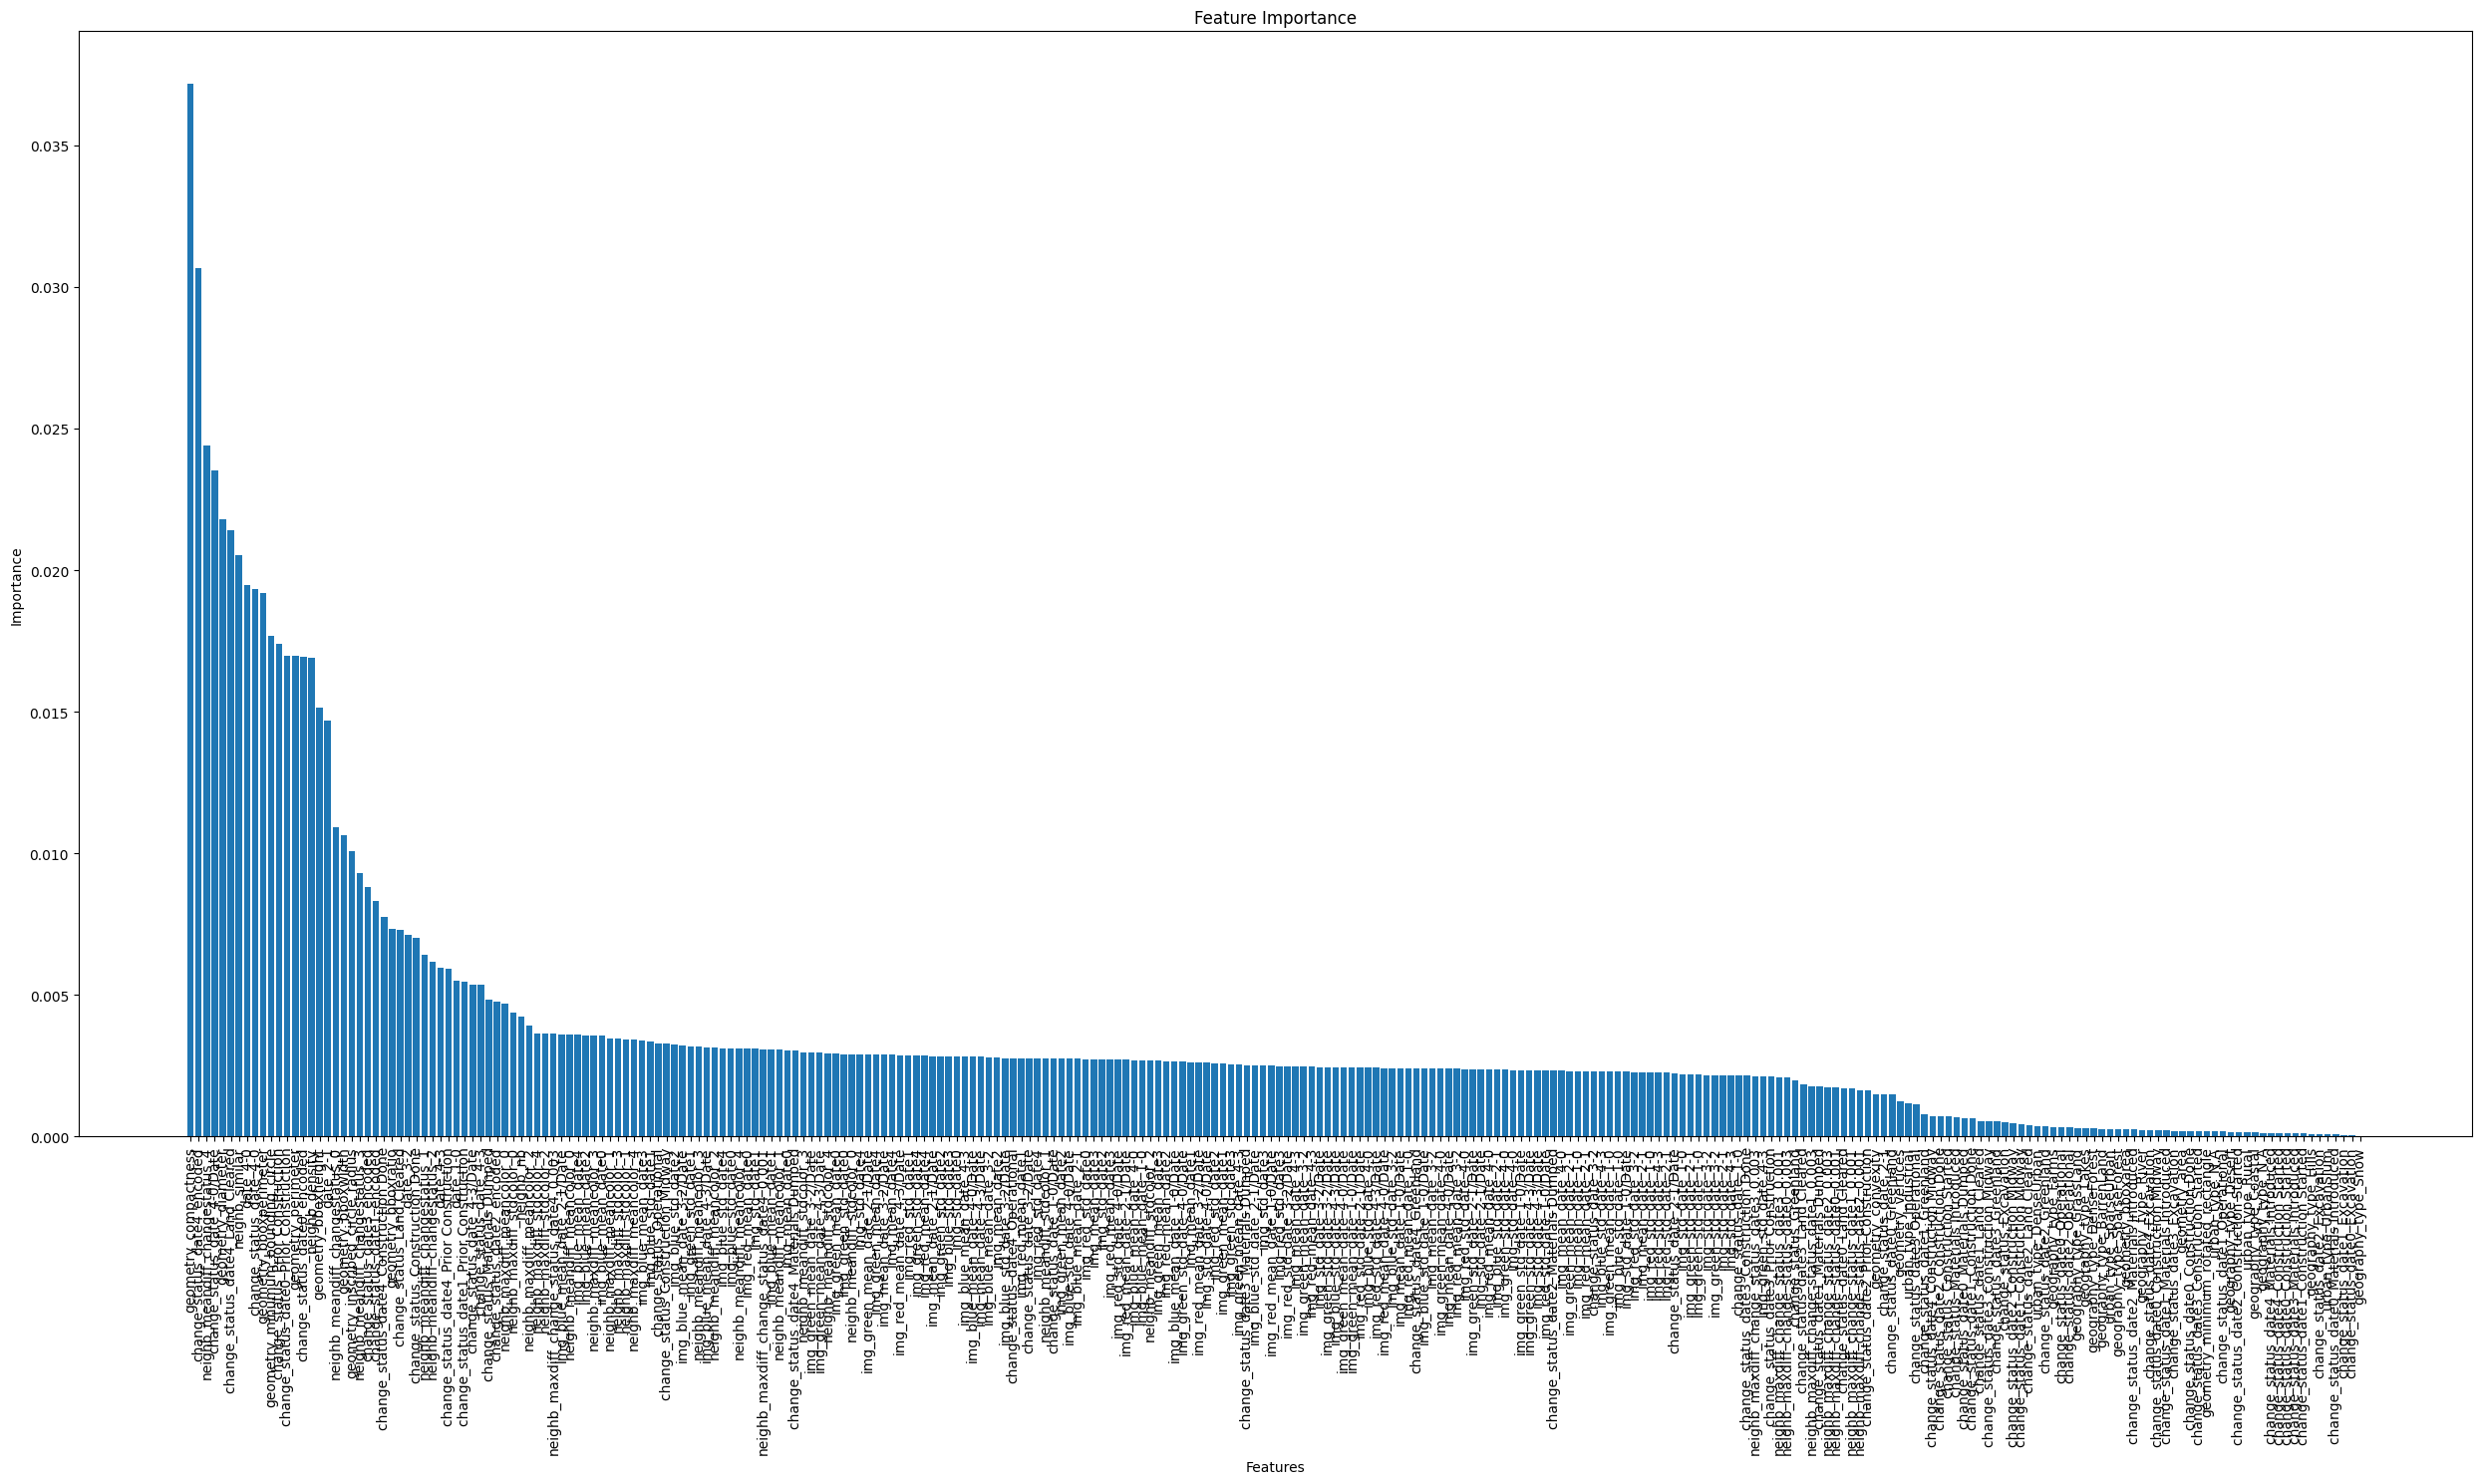

In [23]:

print("==== Importance ====")
# Create a DataFrame to store the feature names and their importance
feature_importance = model.feature_importances_

# Sort the feature importance values along with their corresponding feature names
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Display the sorted feature importance values with their names
for i, (name, importance) in enumerate(zip(sorted_feature_names, sorted_feature_importance)):
    print(f"Feature {i+1}: {name} - Importance: {importance}")
    if i > 10:
        break

# Plotting the feature importances
plt.figure(figsize=(25, 15))
plt.bar(range(len(sorted_feature_importance)), sorted_feature_importance, align='center')
plt.xticks(range(len(sorted_feature_importance)), sorted_feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()    

In [24]:
"""
from sklearn.ensemble import RandomForestClassifier
def objective(trial):
    
    param = {
        'n_estimators': trial.suggest_categorical('n_estimators', [200]),
        'max_depth': trial.suggest_int('max_depth', 40, 80),
        'max_features': trial.suggest_categorical(name="max_features", choices=['auto', 'sqrt']),
        'min_samples_split': trial.suggest_int(name="min_samples_split", low=2, high=20, step=1),
        'min_samples_leaf': trial.suggest_int(name="min_samples_leaf", low=1, high=10, step=1),
        'n_jobs': -1,
        'class_weight': trial.suggest_categorical(name="class_weight", choices=[None, 'balanced', 'balanced_subsample']),
        'random_state':43,
        'criterion':"gini"
    }
    
    model = randomforest = RandomForestClassifier(**param)
    #xgb.XGBRegressor(**param)  
    
    model.fit(X_train,Y_train)
    
    preds = model.predict(X_valid)
    
    score = f1_score(Y_valid, preds, average='weighted')
    
    return score"""

'\nfrom sklearn.ensemble import RandomForestClassifier\ndef objective(trial):\n    \n    param = {\n        \'n_estimators\': trial.suggest_categorical(\'n_estimators\', [200]),\n        \'max_depth\': trial.suggest_int(\'max_depth\', 40, 80),\n        \'max_features\': trial.suggest_categorical(name="max_features", choices=[\'auto\', \'sqrt\']),\n        \'min_samples_split\': trial.suggest_int(name="min_samples_split", low=2, high=20, step=1),\n        \'min_samples_leaf\': trial.suggest_int(name="min_samples_leaf", low=1, high=10, step=1),\n        \'n_jobs\': -1,\n        \'class_weight\': trial.suggest_categorical(name="class_weight", choices=[None, \'balanced\', \'balanced_subsample\']),\n        \'random_state\':43,\n        \'criterion\':"gini"\n    }\n    \n    model = randomforest = RandomForestClassifier(**param)\n    #xgb.XGBRegressor(**param)  \n    \n    model.fit(X_train,Y_train)\n    \n    preds = model.predict(X_valid)\n    \n    score = f1_score(Y_valid, preds, averag

In [25]:
"""
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)"""

"\nstudy = optuna.create_study(direction='maximize')\nstudy.optimize(objective, n_trials=100)\nprint('Number of finished trials:', len(study.trials))\nprint('Best trial:', study.best_trial.params)"

In [26]:

pred_y = model.predict(X_test)

## Save results to submission file
pred_df = pd.DataFrame(pred_y, columns=['change_type'])
pred_df.to_csv("data/RandomForest.csv", index=True, index_label='Id')


In [27]:
pred_probs = model.predict_proba(X_test)
np.save("data/PROBS_RandomForest", pred_probs)